In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pdb
import scipy

%matplotlib inline

In [2]:
def load_mnist():
    data_dir = os.path.join("./data", 'mnist')

    fd = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28,28,1)).astype(np.float)

    fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000)).astype(np.float)

    fd = open(os.path.join(data_dir,'t10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28,28,1)).astype(np.float)

    fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000)).astype(np.float)

    trY = np.asarray(trY)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)


    
    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i,y[i]] = 1.0

    return X/255.,y, y_vec

In [3]:
x, y, y_vec = load_mnist()

x_train = x[0:50000]
y_train = y[0:50000]
y_vec_train = y_vec[0:50000]

x_val = x[50000:55000]
y_val = y[50000:55000]
y_vec_val = y_vec[50000:55000]

x_test = x[55000:]
y_test = y[55000:]
y_vec_test = y_vec[55000:]

In [4]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

# for it in range(10000):
#     X_mb, _ = mnist.train.next_batch(mb_size)

#     _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
#     _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

In [9]:
def run_model(session, D_solver, D_loss, G_solver, G_loss, \
              Xd, yd, epochs=1, batch_size=64, print_every=100, training=True, \
              k_steps=1):
    

    train_indicies = np.arange(Xd.shape[0])
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
 
    
    for e in range(epochs):
            G_LOSS = []
            D_LOSS = []
            for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                for k in range(k_steps):
                    # generate indicies for the batch
                    start_idx = (i*batch_size)%Xd.shape[0]
                    idx = train_indicies[start_idx:start_idx+batch_size]

                    # create a feed dictionary for this batch


                    
                    feed_dict_D = {X: Xd[idx,:].reshape(batch_size, -1),\
                                   Z: sample_Z(batch_size, 100)}
                    # get batch size
                    actual_batch_size = yd[idx].shape[0]


                    if training:
                        _, d_loss= session.run([D_solver, D_loss], feed_dict=feed_dict_D)
                    else:
                        d_loss = session.run([D_loss], feed_dict=feed_dict_D)
            
                # create a feed dictionary for this batch
                feed_dict_G = {Z: sample_Z(batch_size, 100)}
                if training:
                    _, g_loss= session.run([G_solver, G_loss], feed_dict=feed_dict_G)
                else:
                    g_loss = session.run([G_loss], feed_dict=feed_dict_G)
                

                
                
                assert (math.isnan(d_loss) == False and math.isnan(g_loss) == False) == True  


                if training and (i % print_every) == 0:
                    print 'Epoch: {}, Iteration: {}, D_loss: {}, g_loss: {}'.format(e, i, d_loss, g_loss)
            
                G_LOSS.append(g_loss*batch_size)
                D_LOSS.append(d_loss*batch_size)
                
            if training:
                print 'Epoch: {}, D_LOSS: {}, G_LOSS: {}'.format(e, np.sum(D_LOSS)/Xd.shape[0], \
                                                                 np.sum(G_LOSS)/Xd.shape[0])
                 
    
    

In [11]:
# Discriminator Net
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 784], name='X')


D_W1 = tf.get_variable(name='DW1', shape=[784, 128], initializer=tf.contrib.layers.xavier_initializer() )
D_b1 = tf.get_variable(name="Db1", shape=[128], initializer=tf.zeros_initializer())

D_W2 = tf.get_variable('DW2', shape=[128, 1], initializer=tf.contrib.layers.xavier_initializer() )
D_b2 = tf.get_variable(name="Db2", shape=[1], initializer=tf.zeros_initializer())

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = tf.get_variable('GW1', shape=[100, 128], initializer=tf.contrib.layers.xavier_initializer() )

G_b1 = tf.get_variable('Gb1', shape=[128], initializer=tf.zeros_initializer() )

G_W2 = tf.get_variable('GW2', shape=[128, 784], initializer=tf.contrib.layers.xavier_initializer() )
G_b2 = tf.get_variable('Gb2', shape=[784], initializer=tf.zeros_initializer() )

theta_G = [G_W1, G_W2, G_b1, G_b2]

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_real), logits=D_logit_real))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_logit_fake), logits=D_logit_fake))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_fake), logits=D_logit_fake))


# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    # Only update D(X)'s parameters, so var_list = theta_D
    D_solver = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.9, beta2=0.999).minimize(D_loss, var_list=theta_D)
    # Only update G(X)'s parameters, so var_list = theta_G
    G_solver = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.9, beta2=0.999).minimize(G_loss, var_list=theta_G)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,D_solver, D_loss, G_solver, G_loss,x_train,y_train,10000,128,100,True,1)
#     saver = tf.train.Saver(sess)
#     saver.save(sess, 'my_test_model', global_step=1000)
#         print('Validation')
#         run_model(sess,y_out,mean_loss,X_val,y_val,1,64)


NameError: name 'generator' is not defined

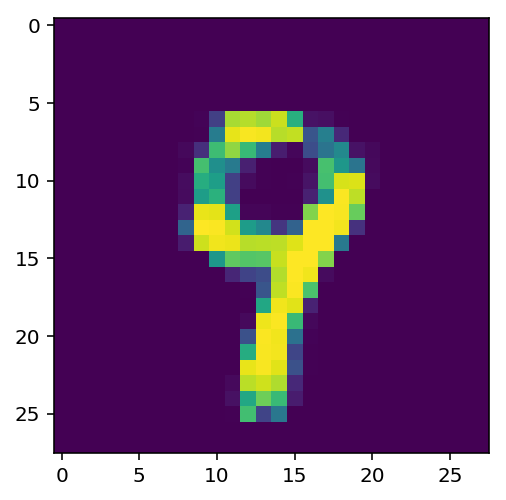

In [28]:
a = sess.run(G_sample, feed_dict={Z:sample_Z(1, 100)})
plt.imshow(a.reshape(28, 28))

In [15]:
# sess=tf.Session()    
# #First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('my_test_model-1000.meta')
# saver.restore(sess,tf.train.latest_checkpoint('./'))



In [72]:
import random, string

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def randomword(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

class DCGAN(object):

    def __init__(self, sess, batch_size=128, epoch=300, train_flag=False):
        

        self.session = sess
        
        self.batch_size = batch_size
        self.epoch = epoch
        
        self.model_dir = './model/'
        
        self.model_save_path = './model/' + 'model.ckpt'

        
        self.training = train_flag
        
        
        self.Z = tf.placeholder(tf.float32, shape=[self.batch_size, 100], name="Z")
        self.X = tf.placeholder(tf.float32, shape=[self.batch_size, 28, 28, 1], name="X")
        self.Y = tf.placeholder(tf.float32, shape=[None, 10], name="Y")
        
#         self.Y_real = tf.placeholder(tf.float32, shape=[None, 1], name="Y_real")
#         self.Y_fake = tf.placeholder(tf.float32, shape=[None, 1], name="Y_fake")

        self.G, self.G_logits = self.model_generator(self.Z, reuse=False)
        self.D, self.D_logits = self.model_discriminator(self.X, reuse=False)
        
        self.sampler = self.sampler(self.Z, reuse=True)
        
        self.DG, self.DG_logits = self.model_discriminator(self.G, reuse=True)
        
        
        
        
        
#         t_vars = tf.trainable_variables()

#         self.d_vars = [var for var in t_vars if 'd' in var.name]
#         self.g_vars = [var for var in t_vars if 'g' in var.name]
        
        self.saver = tf.train.Saver()
        
        self.model_losses()
        
        self.initialize_network()

    def initialize_network(self):
        self.saver = tf.train.Saver()  
        
#         self.session = tf.Session()
        self.init = tf.global_variables_initializer()
        self.session.run(self.init)


    def model_losses(self):
        # losses
        self.dt_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_logits, \
                                                                              labels=tf.ones_like(self.D_logits)))
        
#         self.dt_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.D_logits, labels=self.Y))
        
        
        self.dg_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.DG_logits, \
                                                                              labels=tf.zeros_like(self.DG_logits)))
        self.d_loss = self.dt_loss + self.dg_loss

        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.DG_logits, \
                                                                             labels=tf.ones_like(self.DG_logits)))
        
        # self.d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_logits, labels=self.Y))
        # self.dg_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.DG_logits, labels=self.Y))
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            self.d_train_op = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5, beta2=0.999, name="Adam_D")\
                              .minimize(self.d_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="d"))
            self.g_train_op = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5, beta2=0.999, name="Adam_DG")\
                              .minimize(self.g_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="g"))



    def model_generator(self, Z, reuse=True):

        init_op = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)

        with tf.variable_scope("g", initializer=init_op, reuse=reuse, dtype=tf.float32):
#             tf.scope.reuse_variables()
            with tf.variable_scope("reshape"):
                out = tf.layers.dense(Z, 7 * 7 * 256, activation=None)            
                out = tf.reshape(out, [-1, 7, 7, 256])
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("deconv1"):
                out = tf.layers.conv2d_transpose(out, 128, [3, 3], strides=[2, 2], padding="same")
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("deconv2"):
                out = tf.layers.conv2d_transpose(out, 64, [3, 3], strides=[2, 2], padding="same")
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("output"):
                out = tf.layers.conv2d_transpose(out, 1, [5, 5], strides=[1, 1], padding="same")
                logits = out
                output = tf.nn.tanh(out)
        return output, logits


    def model_discriminator(self, X, reuse=True, trainable=True):

        init_op = tf.contrib.layers.xavier_initializer(uniform=False, dtype=tf.float32)

        with tf.variable_scope("d", initializer=init_op, reuse=reuse, dtype=tf.float32):
#             if reuse:
#                 scope.reuse_variables()
            
            with tf.variable_scope("conv1"):
                out = tf.layers.conv2d(X, 32, [5, 5], strides=[2, 2], padding="same",
                                       trainable=trainable)
                out = tf.layers.batch_normalization(out)
#                 out = tf.nn.relu(out)
                
                out = lrelu(out)
                
#                 out = tf.layers.dropout(out, rate=.0, training=self.training)
                
            with tf.variable_scope("conv2"):
                out = tf.layers.conv2d(out, 64, [3, 3], strides=[2, 2], padding="same",
                                       trainable=trainable)
#                 out = tf.nn.relu(out)
                
                out = lrelu(out)
                
                out = tf.layers.batch_normalization(out)
                
#                 out = tf.layers.dropout(out, rate=.0, training=self.training)

            with tf.variable_scope("conv3"):
                out = tf.layers.conv2d(out, 128, [3, 3], strides=[1, 1], padding="same",
                                       trainable=trainable)
                out = tf.layers.batch_normalization(out)
#                 out = tf.nn.relu(out)
                
                out = lrelu(out)
                
#                 out = tf.layers.dropout(out, rate=.0, training=self.training)

            with tf.variable_scope("output"):                
                out = tf.reshape(out, [self.batch_size, -1 ])
                out = tf.layers.dense(out, 1, activation=None, trainable=trainable)
#                 out = tf.layers.dropout(out, rate=.0, training=self.training)
                logits = out
                output = tf.sigmoid(out)
#         print('number of paramters:', np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
#         j = 0    
#         for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='d'):
#             j = j+1
#         print j
        return output, logits


    def generate(self): 
        if not self.training: 
            print "loading network weights..." 
            self.saver.restore(self.session, self.model_save_path)
            print "...done!" 

        z = np.random.uniform(-1., 1., size=[self.batch_size, 100])
#         gen_images = self.session.run(self.G, feed_dict={self.Z: z})

        gen_images = self.session.run(self.sampler, feed_dict={self.Z: z})
        return gen_images
#         fname = "img_generated_{}.jpg".format(randomword(10))
        
#         plot_title = "generated image"
#         fname = "img_generated_{}.jpg".format(H.get_random_str(5))
#         print()
#         print("writing image to {}...".format(args.img_save_path + fname))
#         H.plot_batch_to_disk(gen_images, args.img_save_path, fname, plot_title)
#         print("...done!")


    def sampler(self, Z, reuse = True):
        init_op = tf.contrib.layers.xavier_initializer(uniform=True, dtype=tf.float32)

        with tf.variable_scope("g", initializer=init_op, reuse=reuse, dtype=tf.float32):
#             tf.scope.reuse_variables()
            with tf.variable_scope("reshape"):
                out = tf.layers.dense(Z, 7 * 7 * 256, activation=None)
                
                out = tf.reshape(out, [-1, 7, 7, 256])
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("deconv1"):
                out = tf.layers.conv2d_transpose(out, 128, [3, 3], strides=[2, 2], padding="same")
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("deconv2"):
                out = tf.layers.conv2d_transpose(out, 64, [3, 3], strides=[2, 2], padding="same")
                out = tf.layers.batch_normalization(out)
                out = tf.nn.relu(out)

            with tf.variable_scope("output"):
                out = tf.layers.conv2d_transpose(out, 1, [5, 5], strides=[1, 1], padding="same")
                logits = out
                output = tf.nn.tanh(out)
            
        return output

#     def save_image(self, images, path):
        
#         return scipy.misc.imsave(path, images)
#         return cv2.imwrite(path, images)

    def train(self, Xd):
#         self.training = True  # for trianing dropout
        
        
        train_dataset_size = Xd.shape[0]
        runs_per_epoch = int(math.ceil(train_dataset_size / self.batch_size))


 
        train_indicies = np.arange(Xd.shape[0])
        
        for e in range(self.epoch):
            
            D_loss = []
            G_loss = []
            
            DEBUG_D = []
            DEBUG_DG = []
            
            
            for run in range(runs_per_epoch):
                # generate indicies for the batch
                start_idx = (run*self.batch_size)%Xd.shape[0]
                idx = train_indicies[start_idx:start_idx+self.batch_size]
                
                # generate G(z) training data
                z = np.random.uniform(-1., 1., size=[self.batch_size, 100])
#                 z = np.random.standard_normal(()).astype(np.float32)
#                 gen_images = self.session.run(self.G, feed_dict={self.Z: z})
                
                dg_loss = self.session.run(self.dg_loss, feed_dict={self.Z: z})
                # train D on real images
                d_r_cost = self.session.run(self.d_loss, feed_dict={self.X: Xd[idx],self.Z: z})
                
#                 if dg_loss > 0.2:
                d_r_train, d_r_cost, debug_selfD = self.session.run([self.d_train_op, self.d_loss, self.D],\
                                                            feed_dict={self.X: Xd[idx], \
                                                                       self.Z: z})

  
                
                # train Generator twice
                for k in range(2):
                    g_train, g_cost, debug_selfDG = self.session.run([self.g_train_op, self.g_loss, self.DG], \
                                                       feed_dict={self.Z: z})
                    
#                 print 'dg_loss:', dg_loss, 'dr_cost:', d_r_cost, 'g_loss:', g_cost


                if run % 50 == 0:

                
                    print 'debug_selfD:', np.mean(debug_selfD), 'debug_selfDG:', np.mean(debug_selfDG)
                
                    print 'Epoch: {}, iteration: {}, d_loss: {}, dg_loss: {}, g_loss: {}'.format(e, run, d_r_cost, dg_loss, g_cost)
                    gen_images = self.session.run(self.sampler, feed_dict={self.Z: z})
                    
                    img_size = image_manifold_size(self.batch_size)    
                    image_merged = merge(gen_images, img_size)
                    
                    save_images(image_merged, './img/img_{}_{}.jpg'.format(e, run))
                    
#                     self.save_image(gen_images[0,:,:,0], './img/img_{}_{}.jpg'.format(e, run))
            
                

                    
                    
                D_loss.append(d_r_cost)
                G_loss.append(g_cost)
                
                DEBUG_D.append(np.mean(debug_selfD))
                DEBUG_DG.append(np.mean(debug_selfDG))
                

                
#             D_LOSS = np.sum(D_loss)/runs_per_epoch
#             G_LOSS = np.sum(G_loss)/runs_per_epoch
            
            
            D_LOSS = np.mean(D_loss)
            G_LOSS = np.mean(G_loss)
            
            DEBUG_D_epoch_mean = np.mean(DEBUG_D)
            DEBUG_DG_epoch_mean = np.mean(DEBUG_DG)
#             gen_images = self.session.run(self.sampler, feed_dict={self.Z: z[0:1,:]})
            
            

#             self.save_image(gen_images[0,:,:,0], './img/img_{}_{}.jpg'.format(e, run))
            
            
            print 'Epoch:{}, D_LOSS: {}, G_LOSS: {}, DEBUG_D_epoch: {}, DEBUG_G_epoch: {}'.\
            format(e, D_LOSS, G_LOSS, DEBUG_D_epoch_mean, DEBUG_DG_epoch_mean)

            print "Saving model to {}...".format(self.model_save_path)
            self.saver.save(self.session, self.model_save_path)
            print "...done!" 

#     def tes       
            
            
                  
    def load(self):
        import re
        print(" [*] Reading checkpoints...")    
        checkpoint_dir = os.path.join(self.model_dir)   
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver = tf.train.import_meta_graph(self.model_save_path+'.meta')
            self.saver.restore(self.session, tf.train.latest_checkpoint(self.model_dir))
            

            print(" [*] Success to read {}".format(ckpt_name))

            return True
        else:
            print(" [*] Failed to find a checkpoint")
            return False
        
       
        

tf.reset_default_graph()

run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

sess = tf.Session(config=run_config)

dc_gan_model = DCGAN(sess, batch_size=64, epoch=25, train_flag=True)
dc_gan_model.load()

# if __name__ == "__main__":
#     net = NetClass()
#     if args.mode == "train":
#         net.train()
#     elif args.mode == "generate":
#         net.generate()
#     print("\nfinished!\n")


 [*] Reading checkpoints...
 [*] Failed to find a checkpoint


False

In [75]:
# self.DG, self.DG_logits
dc_gan_model.train(x_train)

debug_selfD: 0.500444 debug_selfDG: 0.542853
Epoch: 0, iteration: 0, d_loss: 1.39900696278, dg_loss: 0.702961087227, g_loss: 0.61276781559
debug_selfD: 0.505547 debug_selfDG: 0.510231
Epoch: 0, iteration: 50, d_loss: 1.38692903519, dg_loss: 0.703362226486, g_loss: 0.673999130726
debug_selfD: 0.482643 debug_selfDG: 0.509384
Epoch: 0, iteration: 100, d_loss: 1.39025092125, dg_loss: 0.659630656242, g_loss: 0.676512718201
debug_selfD: 0.496971 debug_selfDG: 0.487892
Epoch: 0, iteration: 150, d_loss: 1.37626290321, dg_loss: 0.675976514816, g_loss: 0.718981564045
debug_selfD: 0.475881 debug_selfDG: 0.517511
Epoch: 0, iteration: 200, d_loss: 1.38819932938, dg_loss: 0.643796801567, g_loss: 0.660265564919
debug_selfD: 0.509057 debug_selfDG: 0.509447
Epoch: 0, iteration: 250, d_loss: 1.3766040802, dg_loss: 0.700138688087, g_loss: 0.676174283028
debug_selfD: 0.506667 debug_selfDG: 0.498845
Epoch: 0, iteration: 300, d_loss: 1.39961624146, dg_loss: 0.71846306324, g_loss: 0.696592569351
debug_selfD:

KeyboardInterrupt: 

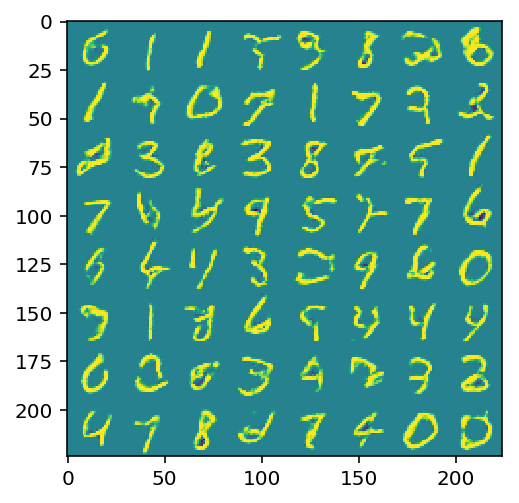

In [74]:
gen_images = dc_gan_model.generate()
img_size = image_manifold_size(64)    
image_merged = merge(gen_images, img_size)
plt.imshow(image_merged)

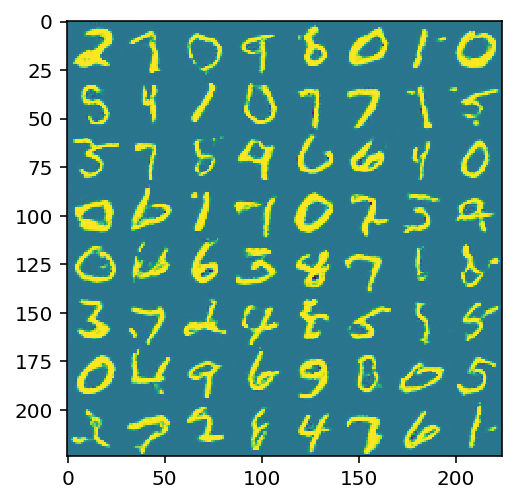

In [48]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter '
                     'must have dimensions: HxW or HxWx3 or HxWx4')
def image_manifold_size(num_images):
    manifold_h = int(np.floor(np.sqrt(num_images)))
    manifold_w = int(np.ceil(np.sqrt(num_images)))
    assert manifold_h * manifold_w == num_images
    return manifold_h, manifold_w    

def save_images(images, path):
    return scipy.misc.imsave(path, images)
    
#       return imsave(inverse_transform(images), size, image_path)

img_size = image_manifold_size(64)    
image_merged = merge(gen_images, img_size)
plt.imshow(image_merged)

In [6]:
gen_images = dc_gan_model.generate()

loading network weights...
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
...done!


In [7]:
gen_images.shape

(64, 28, 28, 1)

In [20]:
from PIL import Image
# img = Image.open('./img/img_18_400.jpg', mode='r')


In [2]:
ls img/

img_0_0.jpg     img_1_250.jpg   img_1_600.jpg   img_2_450.jpg  img_6_350.jpg
img_0_100.jpg   img_12_50.jpg   img_16_0.jpg    img_2_500.jpg  img_6_400.jpg
img_0_150.jpg   img_12_550.jpg  img_16_100.jpg  img_2_50.jpg   img_6_450.jpg
img_0_200.jpg   img_12_600.jpg  img_16_150.jpg  img_2_550.jpg  img_6_500.jpg
img_0_250.jpg   img_12_650.jpg  img_16_200.jpg  img_2_600.jpg  img_6_50.jpg
img_0_300.jpg   img_12_700.jpg  img_16_250.jpg  img_2_650.jpg  img_6_550.jpg
img_0_350.jpg   img_12_750.jpg  img_16_300.jpg  img_2_700.jpg  img_6_600.jpg
img_0_400.jpg   img_1_300.jpg   img_16_350.jpg  img_2_750.jpg  img_6_650.jpg
img_0_450.jpg   img_13_0.jpg    img_16_400.jpg  img_3_0.jpg    img_6_700.jpg
img_0_500.jpg   img_13_100.jpg  img_16_450.jpg  img_3_100.jpg  img_6_750.jpg
img_0_50.jpg    img_13_150.jpg  img_16_500.jpg  img_3_150.jpg  img_7_0.jpg
img_0_550.jpg   img_13_200.jpg  img_1_650.jpg   img_3_200.jpg  img_7_100.jpg
img_0_600.jpg   img_13_250.jpg  img_16_50.jpg   img_3_250.jpg  img_7_150.jpg
im